In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from typing import List

In [39]:
# read and process pathways csv
pathways_df = pd.read_csv('data/pathways.csv')
pathways_df.set_index("Object ID", inplace=True)
pathways_df["Reaction-List"] = pathways_df["Reaction-List"].str.split(" // ")
pathways_df["Species"] = pathways_df["Species"].str.split(" // ")
pathways_df["In-Pathway"] = pathways_df["In-Pathway"].str.split(" // ")
pathways_df["Super-Pathways"] = pathways_df["Super-Pathways"].str.split(" // ")

In [40]:
# read and process reactions csv
reactions_df = pd.read_csv('data/reactions.csv')
reactions_df["Left"] = reactions_df["Left"].str.split(" // ")
reactions_df["Right"] = reactions_df["Right"].str.split(" // ")
reactions_df["In-Pathway"] = reactions_df["In-Pathway"].str.split(" // ")
reactions_df["Substrates"] = reactions_df["Substrates"].str.split(" // ")
reactions_df["Enzymatic-Reaction"] = reactions_df["Enzymatic-Reaction"].str.split(" // ")
reactions_df.set_index("Object ID", inplace=True)

In [42]:
# read and process compounds csv
compounds_df = pd.read_csv("data/compounds.csv")
compounds_df.set_index("Object ID", inplace=True)

In [58]:
# plot graph of reactions and compounds using networkx and graphviz

def plot_reaction_graph(adj_matrix, reactions, compounds):
    """
    Args:
        adj_matrix: np.array, adjacency matrix of the graph
        reactions: list of str, reaction labels
        compounds: list of str, compound labels
        
    The order in adj_matrix corresponds should be: 
        *compounds, *reactions
    """
    node_labels = compounds + reactions
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    mapping = dict(zip(range(len(node_labels)), node_labels))
    G = nx.relabel_nodes(G, mapping)
    group_colors = ['lightblue'] * len(compounds) + ['lightgreen'] * len(reactions)
    plt.figure(figsize=(12, 10))
    pos = graphviz_layout(G, prog='dot')  
    nx.draw(G, pos, with_labels=True, node_color=group_colors, node_size=1000, edge_color='gray', linewidths=1, font_size=10)
    plt.title("Graph Representation of Reactions and Compounds")
    plt.show()

In [59]:
def make_organism_graph(pathway_ids: List[str]) -> (np.array, List[str], List[str]):
    pathways = pathways_df.loc[pathway_ids]
    reactions = set.union(*(set(x) for x in pathways["Reaction-List"]))
    reactions = reactions_df.loc[list(reactions)]
        
    edges, compound_v, reaction_v = set(), set(), set()
    for i, reaction in reactions.iterrows():
        reaction_v.add(i)
        for l in reaction["Left"]:
            compound_v.add(l)
            edges.add((l, i))
        for r in reaction["Right"]:
            compound_v.add(r)
            edges.add((i, r))
    
    vertices = list(compound_v) + list(reaction_v)
    adj_matrix = np.zeros((len(vertices), len(vertices)))
    for edge in edges:
        adj_matrix[vertices.index(edge[0]), vertices.index(edge[1])] = 1
        
    return adj_matrix, list(reaction_v), list(compound_v)

In [60]:
# ORG-6001 - salata rzymska
# https://metacyc.org/META/NEW-IMAGE?object=ORG-6001

salata_pws = pathways_df[
    pathways_df["Species"].map(lambda x: "ORG-6001" in x if type(x) == list else False)
]

salata_pws = set(salata_pws.index)
salata_pws -= {"CAROTENOID-PWY"} # remove super pathway, tego nie chcemy

salata_pws = list(salata_pws)

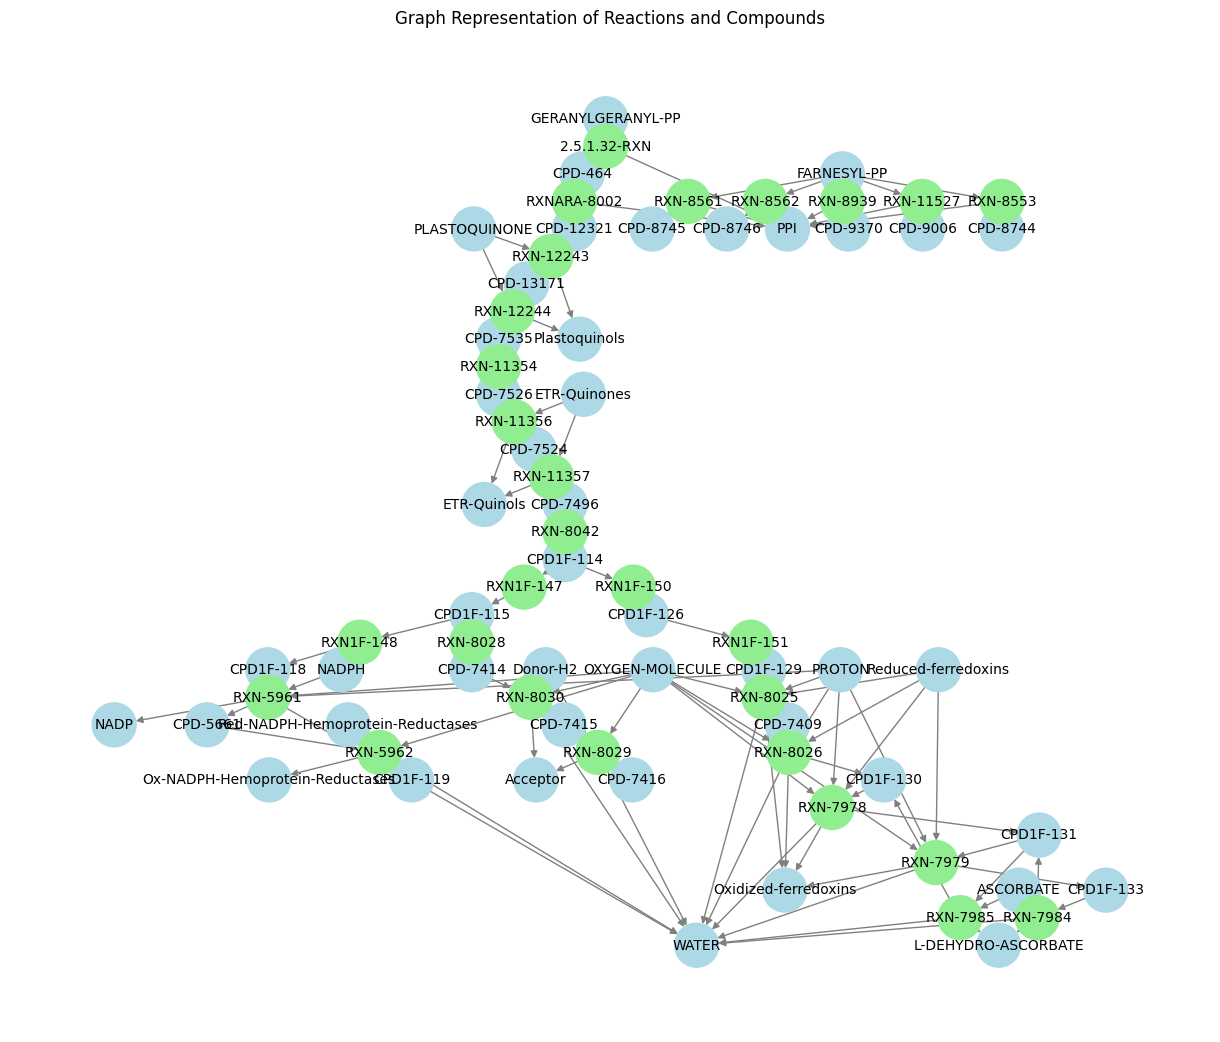

In [61]:
salata_rzymska_graph = make_organism_graph(salata_pws)
plot_reaction_graph(*salata_rzymska_graph)

In [62]:
# same as above but skip reactions, compounds are connected directly

def make_organism_graph_no_reactions(pathway_ids: List[str]) -> (np.array, List[str], List[str]):
    pathways = pathways_df.loc[pathway_ids]
    reactions = set.union(*(set(x) for x in pathways["Reaction-List"]))
    reactions = reactions_df.loc[list(reactions)]
        
    edges, compound_v = set(), set()
    for i, reaction in reactions.iterrows():
        for l in reaction["Left"]:
            compound_v.add(l)
            for r in reaction["Right"]:
                compound_v.add(r)
                edges.add((l, r))
    
    vertices = list(compound_v) 
    adj_matrix = np.zeros((len(vertices), len(vertices)))
    for edge in edges:
        adj_matrix[vertices.index(edge[0]), vertices.index(edge[1])] = 1
        
    return adj_matrix, list(compound_v), []

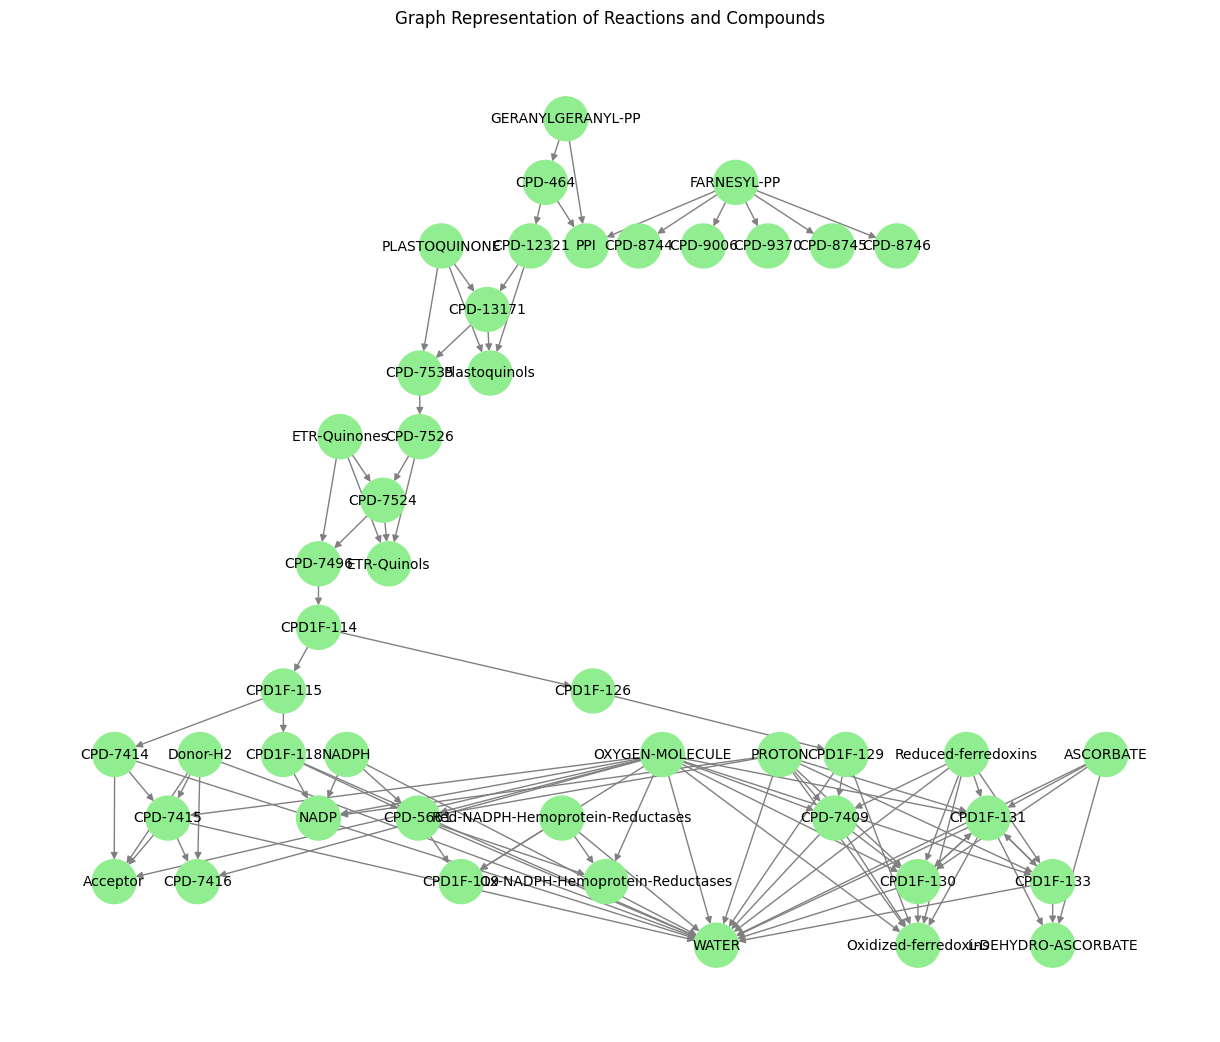

In [63]:
salata_rzymska_graph_no_reactions = make_organism_graph_no_reactions(salata_pws)
plot_reaction_graph(*salata_rzymska_graph_no_reactions)

In [64]:
substrates_count = {}
for substrates in reactions_df["Substrates"]:
    for substrate in substrates:
        if substrate in substrates_count:
            substrates_count[substrate] += 1
        else:
            substrates_count[substrate] = 1
            
compound_popularity = pd.Series(substrates_count, name="Count").sort_values(ascending=False)
compound_popularity

PROTON                    11069
WATER                      8065
OXYGEN-MOLECULE            3193
ATP                        1584
NADPH                      1481
                          ...  
CETRAXATE                     1
CETRAXATE-BENZYL-ESTER        1
CPD-9133                      1
CPD-16353                     1
CPD-20887                     1
Name: Count, Length: 17653, dtype: int64

In [65]:
def remove_compounds_from_graph(
        adj_matrix, reactions, compounds, to_remove
):
    all_labels = compounds + reactions
    indices_to_keep = [i for (i, x) in enumerate(all_labels) if x not in to_remove]
    
    adj_matrix = adj_matrix[indices_to_keep, :][:, indices_to_keep]
    reactions = [r for r in reactions if r not in to_remove]
    compounds = [c for c in compounds if c not in to_remove]
    
    return adj_matrix, reactions, compounds

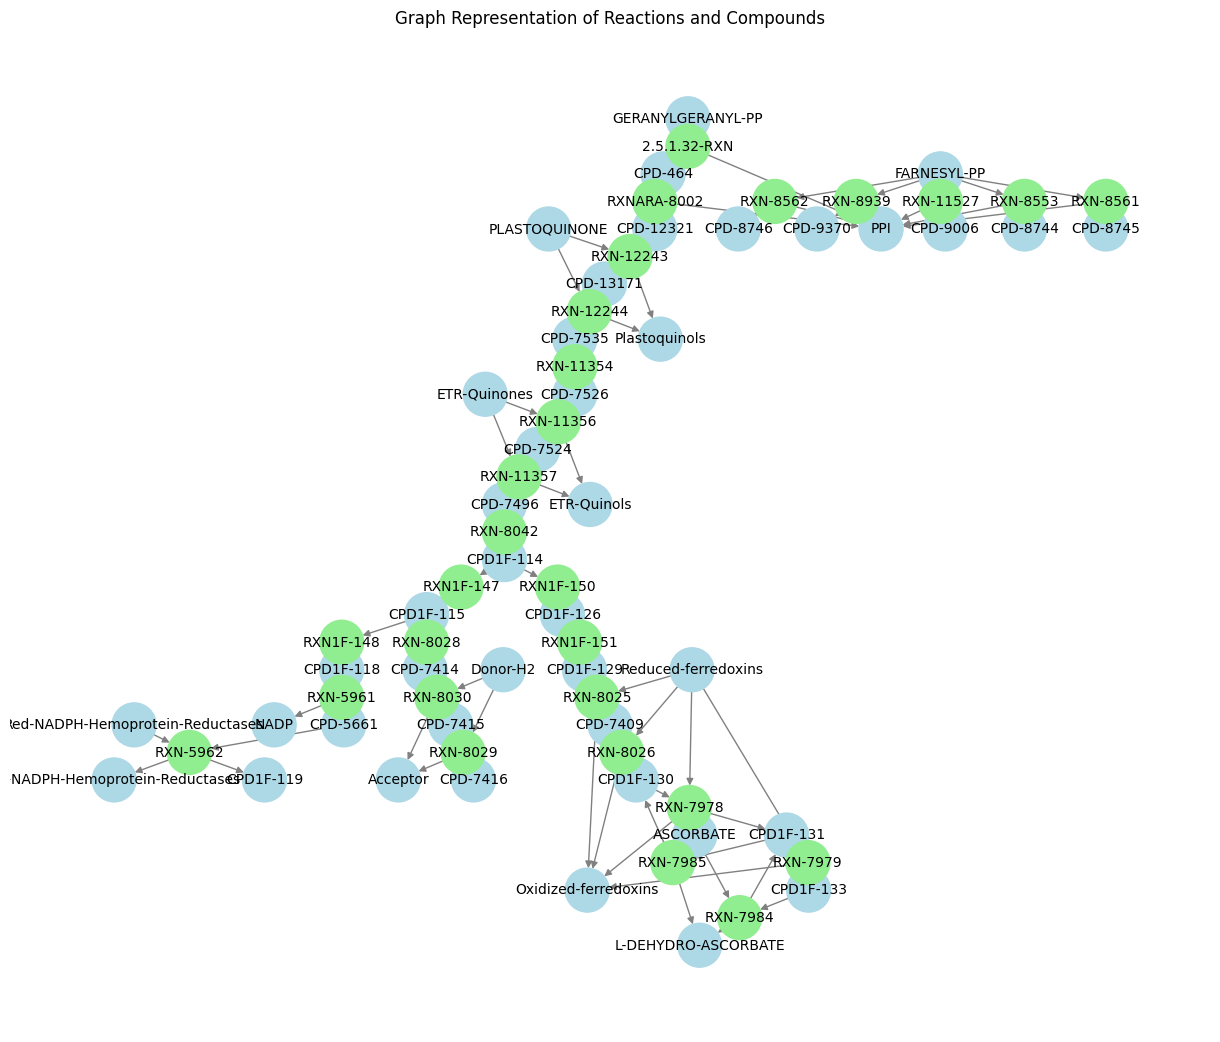

In [66]:
plot_reaction_graph(
    *remove_compounds_from_graph(
        *salata_rzymska_graph,
        to_remove=list(compound_popularity[:5].index)
    )
)

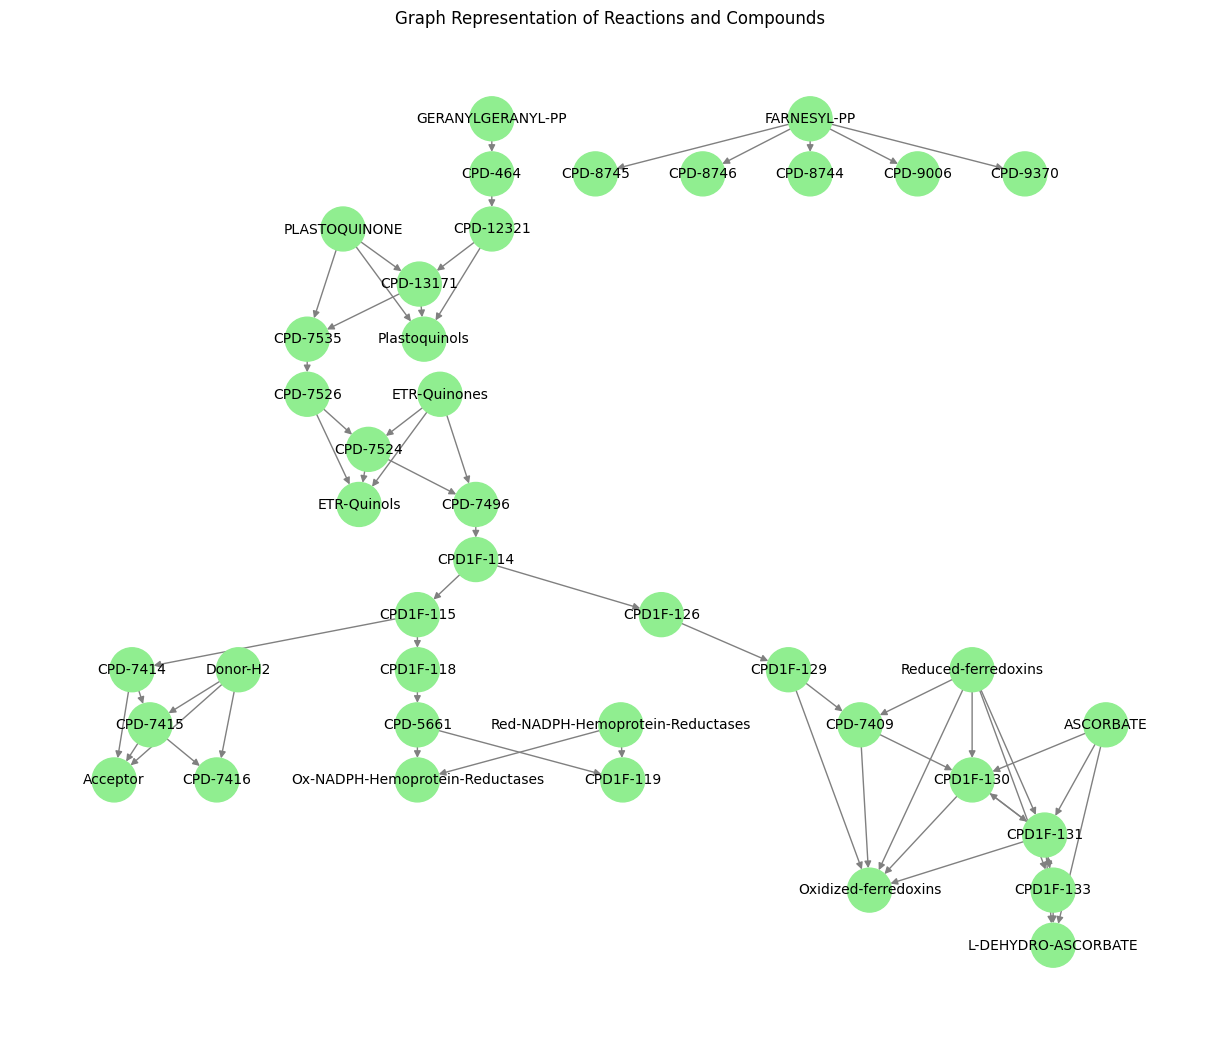

In [67]:
plot_reaction_graph(
    *remove_compounds_from_graph(
        *salata_rzymska_graph_no_reactions,
        to_remove=list(compound_popularity[:15].index)
    )
)

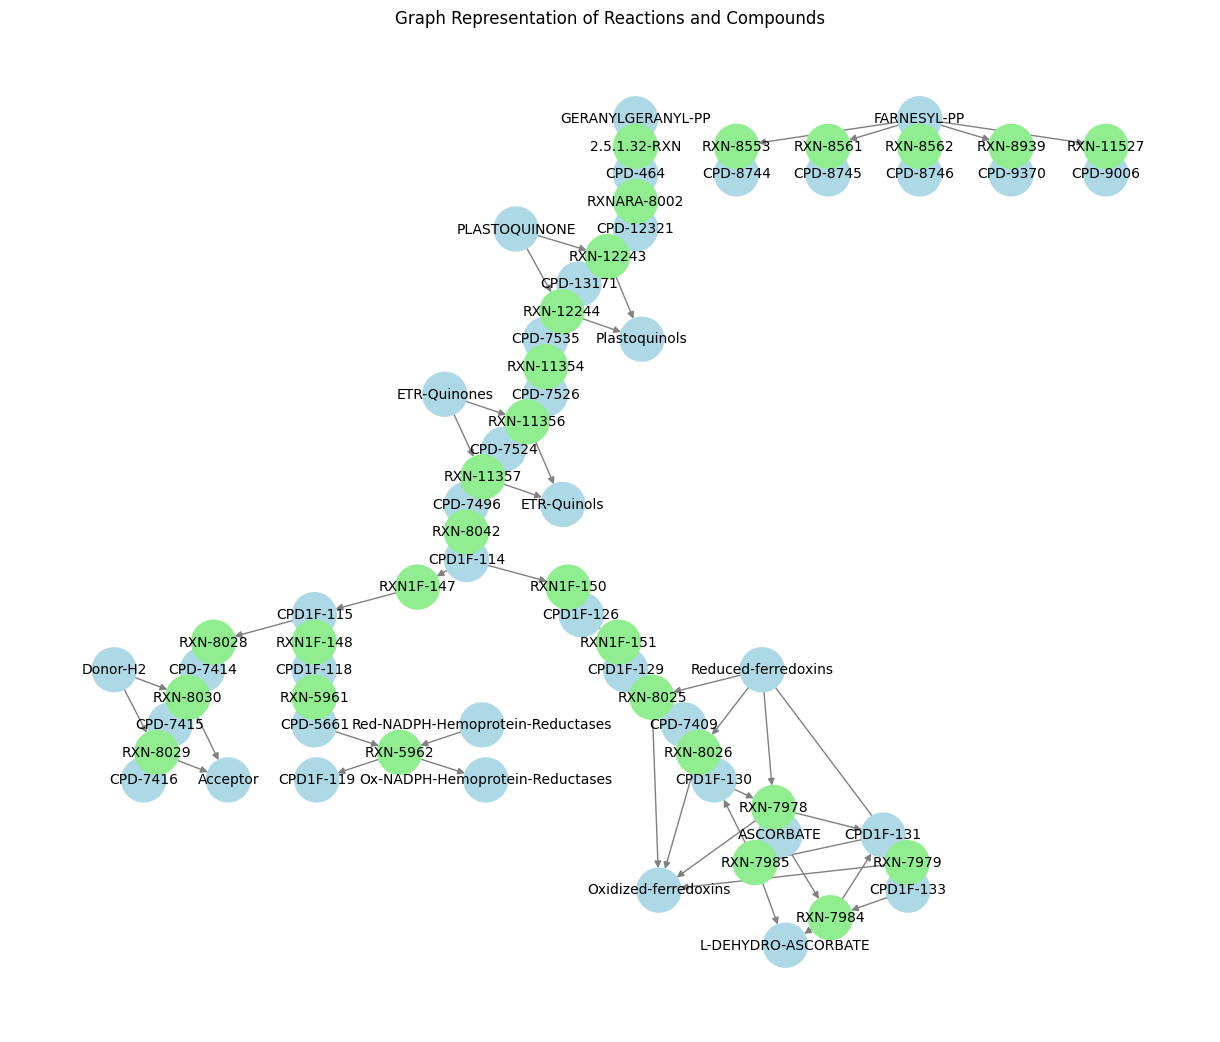

In [68]:
plot_reaction_graph(
    *remove_compounds_from_graph(
        *salata_rzymska_graph,
        to_remove=list(compound_popularity[:15].index)
    )
)